Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name))
  f.close()
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
text = text[1:]

In [5]:
valid_size = 1000 * 40
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99959999 fluence the beliefs of present day anarchists others criticise m
40000 anarchism originated as a term of abuse first used against early


Utility functions to map characters to vocabulary IDs and back.

In [6]:
vocabulary_size = len(string.ascii_lowercase) + 1 + 1 + 1 # [a-z] + ' ' + '.' (eos) + '?' (pad)
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  elif char == '?':  # <pad> symbol
    return vocabulary_size - 1
  elif char == '.':  # <eos> symbol
    return vocabulary_size - 2
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid == vocabulary_size - 1:
    return '?'
  if dictid == vocabulary_size - 2:
    return '.'
  elif dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(27), id2char(0))

Unexpected character: ï
1 26 0 0
a z .  


Function to generate a training batch for the LSTM model.

In [7]:
batch_size=64
num_unrollings=31

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = []
    num_unrollings = np.random.randint(self._num_unrollings - 10, self._num_unrollings)
    for step in range(num_unrollings):
      batches.append(self._next_batch())
    eos = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    eos[:,-2] = 1.
    batches.append(eos)
    pad = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    pad[:,-1] = 1.
    for step in range(num_unrollings, self._num_unrollings):
      batches.append(pad.copy())
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def id2probs(idx):
  probs = np.zeros(shape=vocabulary_size, dtype=np.float)
  probs[idx] = 1.
  return probs

def chars2probs(characters):
  ids = [char2id(c) for c in characters]
  return map(id2probs, ids)

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 2, num_unrollings)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['fluence the beliefs of pre.?????', 'pular especially in the su.?????', 'ers who play a unique part.?????', 'ryon asymmetry of the univ.?????', 'n to the throne in pamplon.?????', 'ndividual competition and .?????', ' with paul at rome during .?????', 'gdom declares martial law .?????', 'reece brussels daegu south.?????', 'les movement toward social.?????', ' the court to the other ha.?????', 'tter being of ted landsmar.?????', ' to gibeon to make sacrifi.?????', 'ng can escape an event hor.?????', 'ere arrested and constitut.?????', ' as a console game as well.?????', ' selected list of cult fil.?????', 'euds a blood feud or vende.?????', 'nd archimedes as one of hi.?????', 'e six zero s drug use and .?????', 'ns to add to labour cnd es.?????', 'to have been built in eith.?????', 'e from columbia university.?????', 'uction to hume s enquiries.?????', 'lso a change of au as in d.?????', 'blin transport space radar.?????', 'ining a digital library is.?????', 'on filter semilattice orde

In [8]:
def string2labels(string):
  body, tail = string.split('.')
  body = ' '.join(map(lambda word: word[::-1], body.split(' ')))
  return chars2probs('.'.join([body, tail]))
  
def reverse_words(batches):
  strings = batches2string(np.array(batches))
  labels = np.array(map(string2labels, strings))
  return labels.transpose((1,0,2))

bg = BatchGenerator(train_text, 2, 30)
bs = bg.next()
print(batches2string(bs))
res = reverse_words(bs)
print(batches2string(res))

['fluence the beliefs of.????????', 'bles available in most.????????']
['ecneulf eht sfeileb fo.????????', 'selb elbaliava ni tsom.????????']


Seq2seq LSTM model

In [9]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))

  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input gate: input, previous output, and bias.
  ix_decoder = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im_decoder = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib_decoder = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx_decoder = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm_decoder = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb_decoder = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx_decoder = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm_decoder = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb_decoder = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox_decoder = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om_decoder = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob_decoder = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output_decoder = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state_decoder = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w_decoder = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b_decoder = tf.Variable(tf.zeros([vocabulary_size]))

  # Definition of the cell computation.
  def lstm_cell_decoder(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix_decoder) + tf.matmul(o, im_decoder) + ib_decoder)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_decoder) + tf.matmul(o, fm_decoder) + fb_decoder)
    update = tf.matmul(i, cx_decoder) + tf.matmul(o, cm_decoder) + cb_decoder
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_decoder) + tf.matmul(o, om_decoder) + ob_decoder)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs = []
  train_labels = []
  train_weights = []
  for _ in range(num_unrollings + 1):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    train_weights.append(tf.placeholder(tf.float32, shape=1))
  
  # Unrolled LSTM loop.
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)

  logits = tf.nn.xw_plus_b(output, w, b)
    
  output_decoder = output
  state_decoder = state
  inp = logits
  output_logits = []
  for _ in range(num_unrollings + 1):
    output_decoder, state_decoder = lstm_cell_decoder(inp, output_decoder, state_decoder)
    inp = tf.nn.xw_plus_b(output_decoder, w_decoder, b_decoder)
    output_logits.append(inp)
    

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output_decoder),
                                saved_state.assign(state_decoder)]):
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(tf.concat(0, output_logits[0]), tf.concat(0, train_labels[0]))\
        * train_weights[0])
    for logits, labels, weight in zip(output_logits[1:], train_labels[1:], train_weights[1:]):
      loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels)) * weight
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1.0, global_step, 3000, 0.9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = output_logits

  # Sampling and validation eval.
  sample_input = list()
  for _ in range(num_unrollings + 1):
    sample_input.append(tf.placeholder(tf.float32, shape=[2,vocabulary_size]))
  saved_sample_output = tf.Variable(tf.zeros([2, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([2, num_nodes]))

  sample_output = saved_sample_output
  sample_state = saved_sample_state
  for i in range(num_unrollings + 1):
    sample_output, sample_state = lstm_cell(sample_input[i], sample_output, sample_state)

  sample_logits = tf.nn.xw_plus_b(sample_output, w, b)
    
  sample_output_decoder = saved_sample_output
  sample_state_decoder = sample_state
  sample_inp = sample_logits
  sample_output_logits = []
  for _ in range(num_unrollings + 1):
    sample_output_decoder, sample_state_decoder = lstm_cell_decoder(
        sample_inp, sample_output_decoder, sample_state_decoder)
    sample_inp = tf.nn.xw_plus_b(sample_output_decoder, w_decoder, b_decoder)
    sample_output_logits.append(sample_inp)

  # Predictions.
  valid_prediction = sample_output_logits

In [11]:
num_steps = 100001
summary_frequency = 500
mean_losses = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    labels = reverse_words(batches)
    batches = batches[::-1]
    weights = np.ones(len(batches))
    weights = weights / weights.sum()
    
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_inputs[i]] = batches[i]
      feed_dict[train_labels[i]] = labels[i]
      feed_dict[train_weights[i]] = [weights[i]]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      mean_losses.append(mean_loss)
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
    
      if step % (summary_frequency * 5) == 0:
        val_batches = valid_batches.next()
        print(batches2string(val_batches))
        val_batches = val_batches[::-1]
        feed_valid = dict()
        for i in range(num_unrollings + 1):
          feed_valid[sample_input[i]] = val_batches[i]
        val_prediction = session.run([valid_prediction], feed_dict=feed_valid)
        val_prediction = val_prediction[0]
        print(batches2string(np.array(val_prediction)))

Initialized
Average loss at step 0: 3.375561 learning rate: 1.000000
['ng class radicals including .???', ' policy and anarchist votes .???']
['????????????????????????????????', '????????????????????????????????']
Average loss at step 500: 2.867676 learning rate: 1.000000
Average loss at step 1000: 2.764175 learning rate: 1.000000
Average loss at step 1500: 2.636457 learning rate: 1.000000
Average loss at step 2000: 2.576946 learning rate: 1.000000
Average loss at step 2500: 2.508032 learning rate: 1.000000
['the diggers of the english r.???', 'helped bring the popular fro.???']
['eei ee e                   .????', 'eeie e e                   .????']
Average loss at step 3000: 2.160964 learning rate: 0.900000
Average loss at step 3500: 2.097931 learning rate: 0.900000
Average loss at step 4000: 2.065554 learning rate: 0.900000
Average loss at step 4500: 2.006832 learning rate: 0.900000
Average loss at step 5000: 1.960332 learning rate: 0.900000
['evolution and the sans culotte.?', 'nt

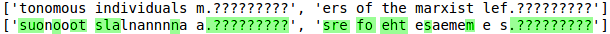

In [14]:
from IPython.display import Image
Image("seq2seq.png")

График средней ошибки, взятой на 100 последних батчах (ошибка на батче считается до обучения на нём, и каждый семпл участвует в обучение единожды)

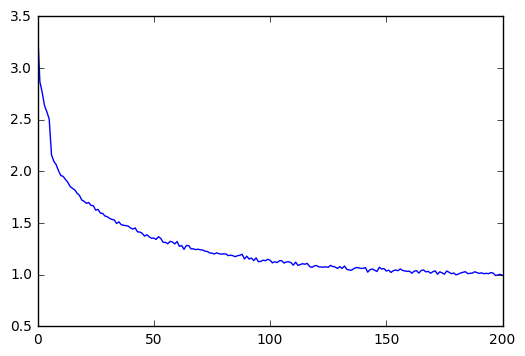

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_losses)

Для простоты и более быстрой сходимости генерирую предложения только длины 22-31, добавляю символ конца предложения - '.' и до 32-х добиваю символом padding - '?'. Генерирую батч из предложений равной длины (случайной в промежутке 22-31) и кормлю модели на одной итерации.

В sequence loss было решено добавить ошибку на padding символах, потому что так модель обучалась лучше. Также настроил learning_rate. Начальные размер батча (64) и число нод (64) оказались оптимальными.

При обучении вывожу результаты работы модели на предложениях из валидационной выборки (не участвующих в обучении). Видно как в начале модель учится определять конец предложения и выдавать паддинги после него. Вместо предложения сперва модель просто выдает пробелы, что дает гарантированно несколько матчингов (логично). После этого модель начинает распозновать позиции пробелов и выводить на места слов буквы вместо пробелов. По началу генерируются просто частотные символы, что опять же даёт гарантированый матчинг. Затем можно наблюдать, как алгоритм в действительности разворачивает некоторые слова полностью или частично.

В конце концов у меня получилось научить модель довольно качественно разворачивать короткие слова (1-3 символа), особенно частотные типа 'the'. Также она неплохо справляется с длинными словами, правильно разворачивая хотя бы несколько символов.